In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, concatenate, GRU, Reshape, BatchNormalization, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Nadam
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv(open("df_whole.csv", 'rb'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176954 entries, 0 to 176953
Columns: 145 entries, seq_overlap to fickett_score-full-sequence
dtypes: float64(138), int64(5), object(2)
memory usage: 195.8+ MB


In [3]:
df['label'].value_counts()

label
1    95558
0    81396
Name: count, dtype: int64

In [4]:
df.head()

,seq_overlap,seq_med,label,n_start,n_end,AA,AC,AG,AT,CA,...,std_ORF_length,average_ORF_length,cv_ORF_length,maximum_GC_content_ORF,minimum_GC_content_ORF,std_GC_content_ORF,average_GC_content_ORF,cv_GC_content_ORF,fickett_score-ORF,fickett_score-full-sequence
0,ATCGATTGTCAGTGGTTCCTTTTCATCCATTGATACTGCACGCTGG...,GAAGCTAAACTCGTCACCTTCACGGACAACACGGGCTGACAGGCTG...,1,0,299,0.070234,0.086957,0.050167,0.056856,0.073579,...,21.266170,31.5,0.675117,61.538462,33.333333,11.231747,52.586996,0.213584,1.1004,0.44552
1,AGTAACCTTAGCGTTATCGCGATCCACCGCCAGCAGATACTGCGTC...,GGTAAACAACGACGCGTACTCTTCATAAATACGCACGGCGCGATAA...,0,0,0,0.080268,0.060201,0.033445,0.063545,0.066890,...,16.085708,37.5,0.428952,61.111111,25.000000,14.074283,48.958333,0.287475,1.2250,0.41599
2,AGCTGGACAAAAACAGCAAATACCGTAGCTATTATTATTGGCGTCC...,ACTATATCAATCAGCAGGCAGAGCCGAAGCCCTTTCAGCCAAATGG...,1,0,299,0.110368,0.036789,0.083612,0.093645,0.080268,...,26.495283,36.0,0.735980,48.611111,37.037037,4.786439,43.364198,0.110378,1.1274,0.47360
3,CTCCATGCTGCTTTCAGTATTTGTGGCAATGAGCCTGACCCCTGCC...,ACCTTCCGGTGCCACCATGGTTAACACCACGAAAGTGCTGCAACAG...,1,0,299,0.083612,0.060201,0.050167,0.043478,0.063545,...,0.000000,144.0,0.000000,55.555556,55.555556,0.000000,55.555556,0.000000,1.2952,0.44369
4,AAACAGTATTCAGGGGTCAATGTCCTGAAAGGCATCGATTTTACGT...,CAGAAAATGAAGAACTTGCTGGCGGCGCTGGGCTGCCAGTTTGATC...,1,0,299,0.063545,0.033445,0.036789,0.070234,0.030100,...,51.000000,93.0,0.548387,59.523810,51.388889,4.067460,55.456349,0.073345,1.2560,0.44988


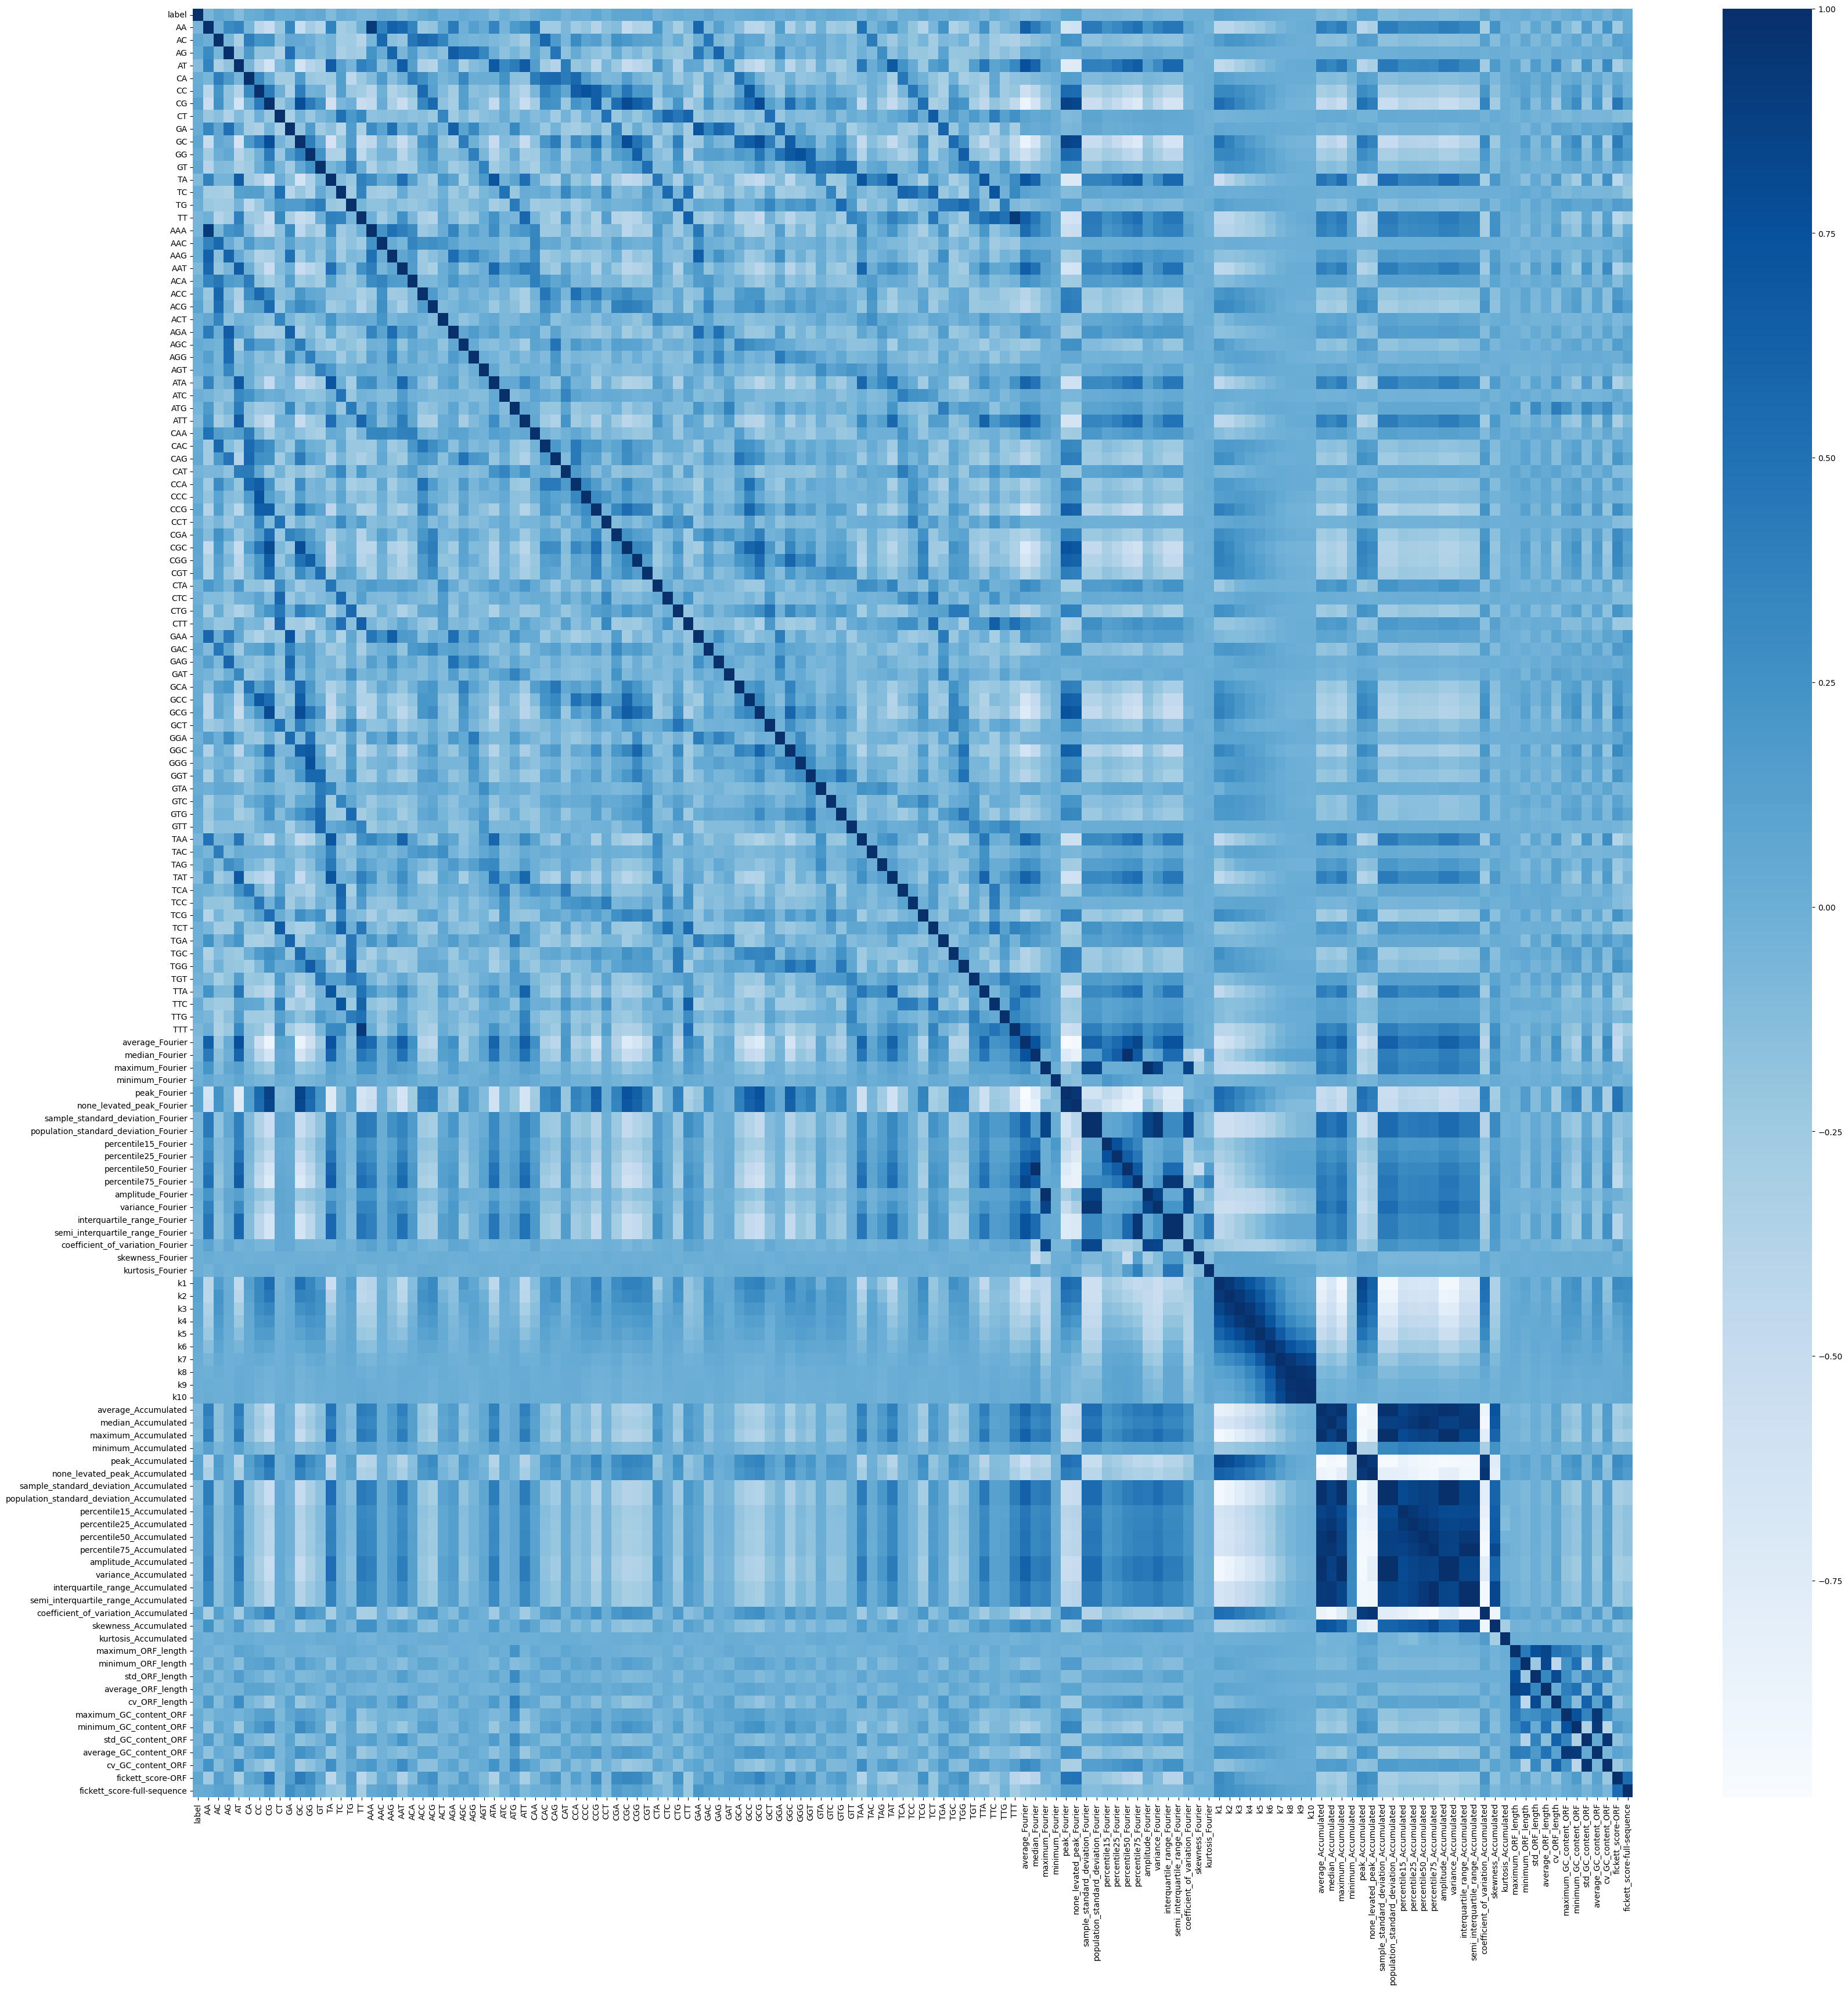

In [7]:
plt.figure(figsize = (40, 40))
sns.heatmap(df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end'], axis = 1).corr(), cmap = 'Blues')
plt.show()

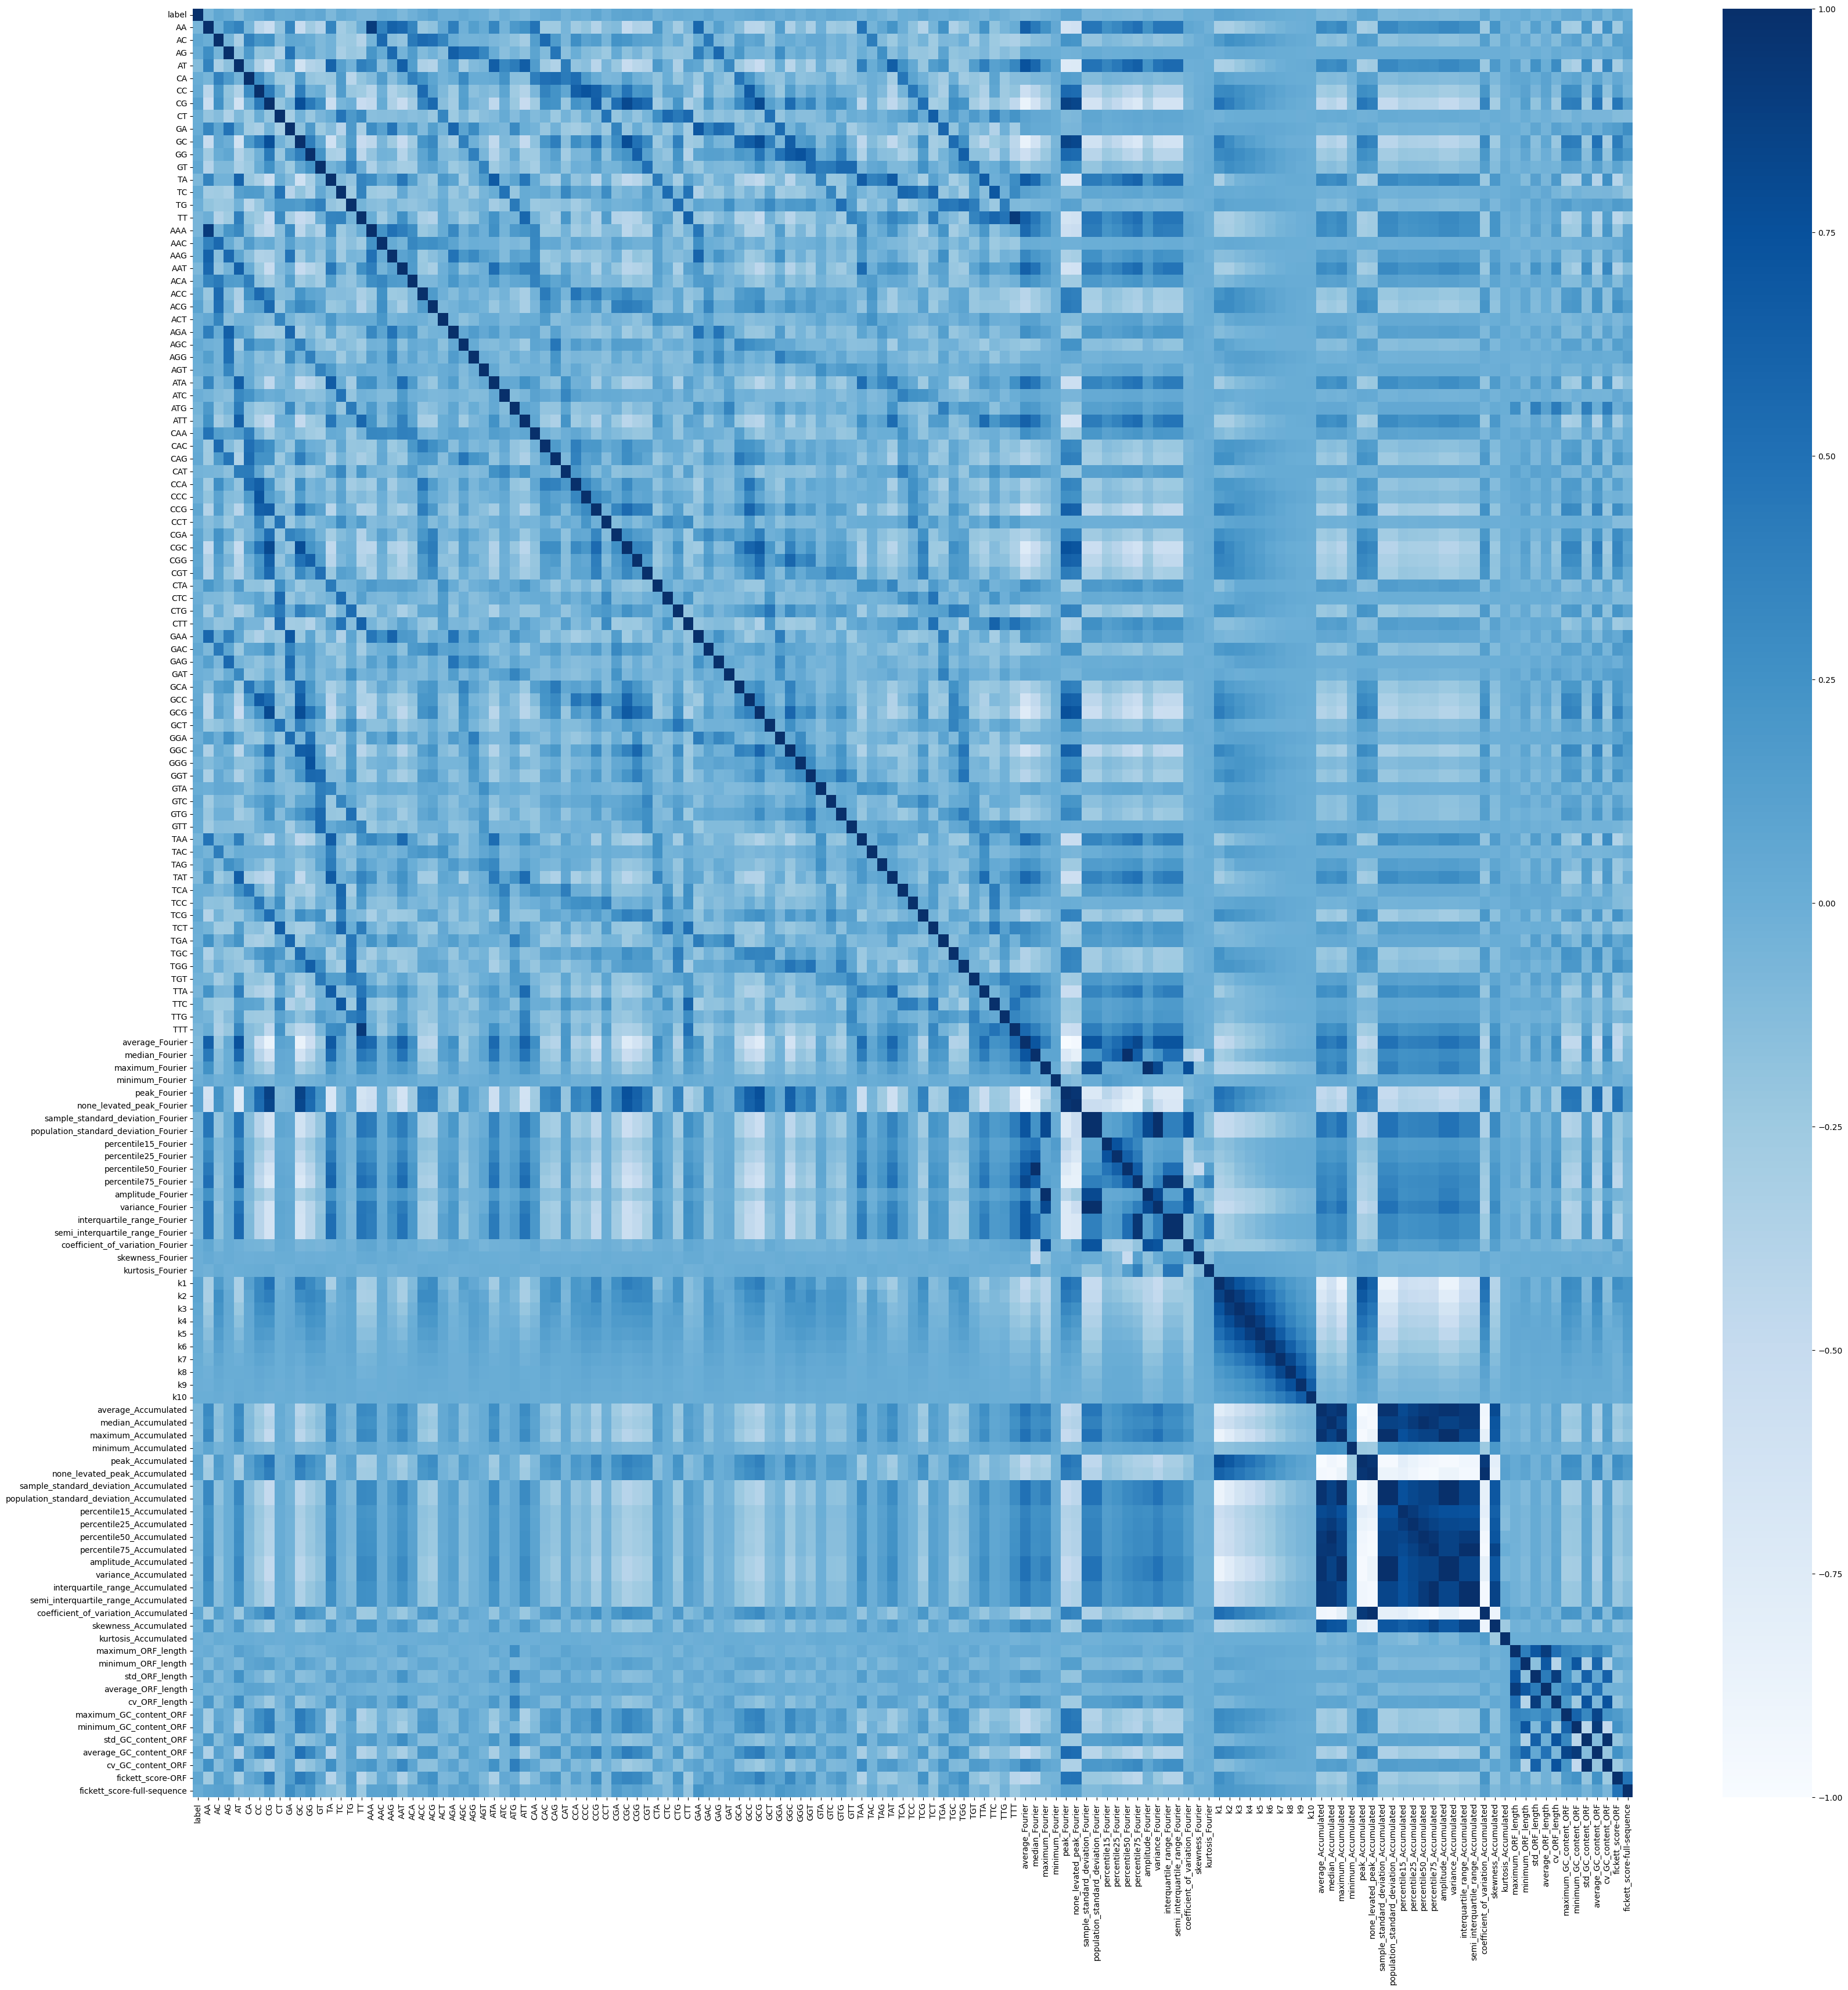

In [8]:
plt.figure(figsize = (40, 40))
sns.heatmap(df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end'], axis = 1).corr(method = 'spearman'), cmap = 'Blues')
plt.show()

In [12]:
cor = df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end'], axis = 1).corr()
cor_target = abs(cor["label"])

relevant_features = cor_target
relevant_features = pd.DataFrame(relevant_features)
relevant_features.sort_values("label" , ascending = False)[: 20]

,label
label,1.000000
AT,0.126798
k1,0.118633
CG,0.117797
population_standard_deviation_Accumulated,0.112247
sample_standard_deviation_Accumulated,0.112247
amplitude_Accumulated,0.112223
maximum_Accumulated,0.112223
variance_Accumulated,0.110308
TAT,0.109333


In [13]:
cor = df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end'], axis = 1).corr(method = 'spearman')
cor_target = abs(cor["label"])

relevant_features = cor_target
relevant_features = pd.DataFrame(relevant_features)
relevant_features.sort_values("label" , ascending = False)[: 20]

,label
label,1.000000
AT,0.120713
CG,0.118181
TAT,0.102855
k1,0.099585
variance_Accumulated,0.097838
population_standard_deviation_Accumulated,0.097838
sample_standard_deviation_Accumulated,0.097838
maximum_Accumulated,0.097823
amplitude_Accumulated,0.097823


In [16]:
cor_target = df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end'], axis = 1).corr(method = 'spearman')['label']
cor_with_random = df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end'], axis = 1).corrwith(df['random_variable'], method = 'spearman')
relevant_features = cor_target[abs(cor_target) < abs(cor_with_random)]
print(relevant_features)

AAG                 0.006011
TCC                -0.000279
TGG                 0.001101
skewness_Fourier   -0.001017
k9                 -0.000008
random_variable     0.000732
Name: label, dtype: float64


In [5]:
df = df.drop(['AAG', 'TCC', 'TGG', 'skewness_Fourier', 'k9'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176954 entries, 0 to 176953
Columns: 140 entries, seq_overlap to fickett_score-full-sequence
dtypes: float64(133), int64(5), object(2)
memory usage: 189.0+ MB


In [29]:
forestmodel = RandomForestClassifier(n_estimators = 2048, max_depth = 11)
forestmodel.fit(df.drop(['label', 'seq_overlap', 'seq_med', 'n_start', 'n_end'], axis = 1), df['label'])

feature_importances = forestmodel.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': df.drop(['label', 'seq_overlap', 'seq_med', 'n_start', 'n_end'], axis = 1).columns,
                                      'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

for index, row in feature_importance_df.iterrows():
    print(f"{row['Feature']} : {row['Importance']:.4f}")

CG : 0.0369
average_Fourier : 0.0275
AT : 0.0264
peak_Fourier : 0.0240
none_levated_peak_Fourier : 0.0233
k1 : 0.0171
GC : 0.0152
fickett_score-ORF : 0.0145
ACG : 0.0130
CGT : 0.0126
TA : 0.0118
TAT : 0.0117
variance_Accumulated : 0.0117
GGG : 0.0115
k2 : 0.0115
population_standard_deviation_Accumulated : 0.0114
CTT : 0.0114
sample_standard_deviation_Accumulated : 0.0110
maximum_Accumulated : 0.0107
percentile75_Fourier : 0.0104
amplitude_Accumulated : 0.0103
CGC : 0.0102
AC : 0.0094
k3 : 0.0093
ATA : 0.0092
fickett_score-full-sequence : 0.0091
TTC : 0.0089
GG : 0.0088
TTT : 0.0088
CC : 0.0085
median_Fourier : 0.0085
percentile50_Fourier : 0.0084
k4 : 0.0083
TC : 0.0083
semi_interquartile_range_Fourier : 0.0079
interquartile_range_Fourier : 0.0078
k5 : 0.0077
TT : 0.0077
variance_Fourier : 0.0076
average_GC_content_ORF : 0.0076
GCG : 0.0076
peak_Accumulated : 0.0076
GT : 0.0076
population_standard_deviation_Fourier : 0.0076
average_Accumulated : 0.0075
sample_standard_deviation_Fourier

C:\Users\misha\AppData\Local\Temp\ipykernel_7096\1437758562.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Importance', y = df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end', 'label'], axis = 1).columns[:l],


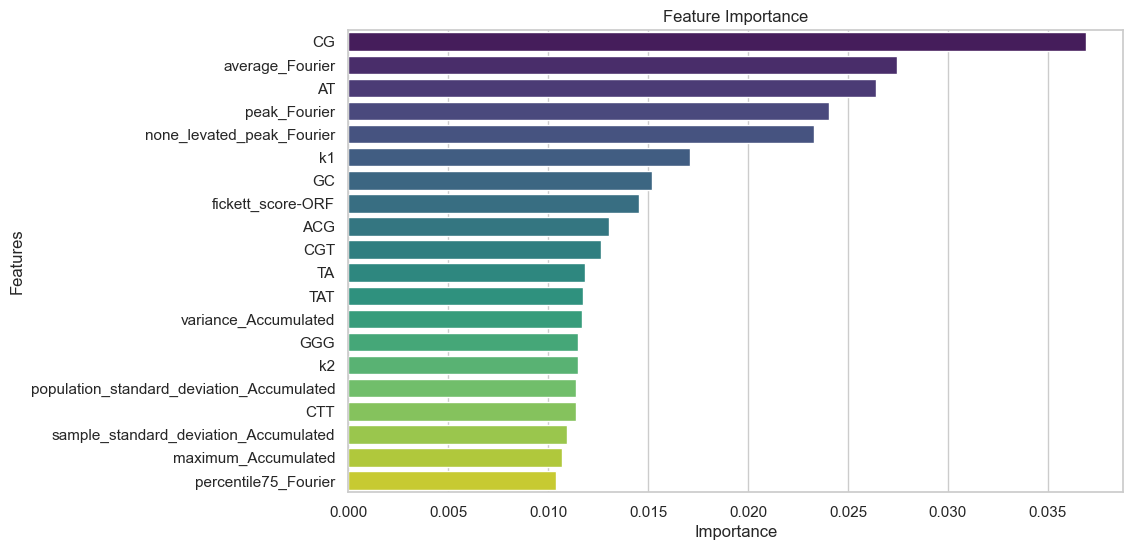

In [38]:
l = 20
sns.set(style="whitegrid")

plt.figure(figsize = (10, 6))
sns.barplot(x = 'Importance', y = df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end', 'label'], axis = 1).columns[:l],
             data = feature_importance_df[:l], palette = "viridis")

plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.savefig("teature_importanse.png")

plt.show()

In [30]:
top_features = feature_importance_df.head(40)['Feature'].tolist()
top_features

['CG',
 'average_Fourier',
 'AT',
 'peak_Fourier',
 'none_levated_peak_Fourier',
 'k1',
 'GC',
 'fickett_score-ORF',
 'ACG',
 'CGT',
 'TA',
 'TAT',
 'variance_Accumulated',
 'GGG',
 'k2',
 'population_standard_deviation_Accumulated',
 'CTT',
 'sample_standard_deviation_Accumulated',
 'maximum_Accumulated',
 'percentile75_Fourier',
 'amplitude_Accumulated',
 'CGC',
 'AC',
 'k3',
 'ATA',
 'fickett_score-full-sequence',
 'TTC',
 'GG',
 'TTT',
 'CC',
 'median_Fourier',
 'percentile50_Fourier',
 'k4',
 'TC',
 'semi_interquartile_range_Fourier',
 'interquartile_range_Fourier',
 'k5',
 'TT',
 'variance_Fourier',
 'average_GC_content_ORF']

In [6]:
top_features = ['CG',
                'average_Fourier',
                'AT',
                'peak_Fourier',
                'none_levated_peak_Fourier',
                'k1',
                'GC',
                'fickett_score-ORF',
                'ACG',
                'CGT',
                'TA',
                'TAT',
                'variance_Accumulated',
                'GGG',
                'k2',
                'population_standard_deviation_Accumulated',
                'CTT',
                'sample_standard_deviation_Accumulated',
                'maximum_Accumulated',
                'percentile75_Fourier',
                'amplitude_Accumulated',
                'CGC',
                'AC',
                'k3',
                'ATA',
                'fickett_score-full-sequence',
                'TTC',
                'GG',
                'TTT',
                'CC',
                'median_Fourier',
                'percentile50_Fourier',
                'k4',
                'TC',
                'semi_interquartile_range_Fourier',
                'interquartile_range_Fourier',
                'k5',
                'TT',
                'variance_Fourier',
                'average_GC_content_ORF']

df = df[top_features + ['seq_overlap', 'seq_med', 'n_start', 'n_end', 'label']]

In [33]:
df.head(20)

,CG,average_Fourier,AT,peak_Fourier,none_levated_peak_Fourier,k1,GC,fickett_score-ORF,ACG,CGT,...,interquartile_range_Fourier,k5,TT,variance_Fourier,average_GC_content_ORF,seq_overlap,seq_med,n_start,n_end,label
0,0.076923,381.0,0.056856,0.262467,5.780577,1.998517,0.070234,1.1004,0.030201,0.016779,...,379.389404,7.920569,0.080268,165833.779264,52.586996,ATCGATTGTCAGTGGTTCCTTTTCATCCATTGATACTGCACGCTGG...,GAAGCTAAACTCGTCACCTTCACGGACAACACGGGCTGACAGGCTG...,0,299,1
1,0.107023,347.0,0.063545,0.288184,6.106303,1.993012,0.107023,1.2250,0.026846,0.010067,...,387.068540,7.844456,0.056856,125467.224080,48.958333,AGTAACCTTAGCGTTATCGCGATCCACCGCCAGCAGATACTGCGTC...,GGTAAACAACGACGCGTACTCTTCATAAATACGCACGGCGCGATAA...,0,0,0
2,0.030100,421.0,0.093645,0.237530,5.576850,1.972394,0.056856,1.1274,0.006711,0.000000,...,560.930488,7.720284,0.086957,165772.575251,43.364198,AGCTGGACAAAAACAGCAAATACCGTAGCTATTATTATTGGCGTCC...,ACTATATCAATCAGCAGGCAGAGCCGAAGCCCTTTCAGCCAAATGG...,0,299,1
3,0.080268,361.0,0.043478,0.277008,6.106677,1.997170,0.066890,1.2952,0.013423,0.030201,...,369.216273,7.881685,0.063545,186878.929766,55.555556,CTCCATGCTGCTTTCAGTATTTGTGGCAATGAGCCTGACCCCTGCC...,ACCTTCCGGTGCCACCATGGTTAACACCACGAAAGTGCTGCAACAG...,0,299,1
4,0.096990,343.0,0.070234,0.291545,6.170549,1.988668,0.113712,1.2560,0.006711,0.006711,...,324.510181,7.759931,0.060201,168477.591973,55.456349,AAACAGTATTCAGGGGTCAATGTCCTGAAAGGCATCGATTTTACGT...,CAGAAAATGAAGAACTTGCTGGCGGCGCTGGGCTGCCAGTTTGATC...,0,299,1
5,0.036789,427.0,0.103679,0.234192,5.613298,1.966152,0.060201,1.1386,0.010067,0.006711,...,529.682901,7.852107,0.130435,264868.896321,37.046137,TTTTTCTTCATATTCTGTCATAATATTGCCTTCCAGATTGCTGTTA...,ATCTATATTCAGAAGCTTTACATTCTGCGCTTCGCTGTCTTTTACT...,0,299,1
6,0.043478,423.0,0.066890,0.236407,5.630819,1.964154,0.076923,0.8003,0.000000,0.006711,...,423.929706,7.667549,0.137124,229721.739130,52.500000,AGGGGCATATCACCGCTTTCGTTCAAGACAGAATCAAAGCCGGCCT...,TTGCAGGTGTCAGAAAAAACAAAATGCGCTCTCAAAAGGAGATTGT...,0,0,0
7,0.056856,405.0,0.066890,0.246914,5.671859,1.987578,0.076923,0.8463,0.013423,0.013423,...,463.707996,7.825080,0.117057,172966.555184,34.116809,TAATTGAAGCATGTTCAAGAATACGCCAGGATAAAAACTTCAGATG...,TATCCCACAGCAACGGGTTGGGCAGCAACACGTTTTGCTGAAAGCG...,0,0,0
8,0.073579,377.0,0.053512,0.265252,5.837295,1.992519,0.056856,0.8669,0.016779,0.026846,...,436.752579,7.934083,0.090301,131996.989967,37.037037,CGGGCCTTGGCACCGGCAATAATACGTGTATCCGACGTGACCACTT...,CGGATTTCTGTGTCGTCCAACTGTTGCAGCAAATATTCATCCGCCG...,0,299,1
9,0.086957,351.0,0.050167,0.284900,6.095009,1.971421,0.080268,1.2713,0.033557,0.013423,...,393.036541,7.844456,0.053512,137804.347826,33.666667,GCGTTGCATCCGGCATTTGGCTCCTGTTGCCGGATGCGGCGTGAAC...,ATACACCGCCTACCACGCACGCCGCGATAGCATCCAGCTCATACAT...,0,299,1


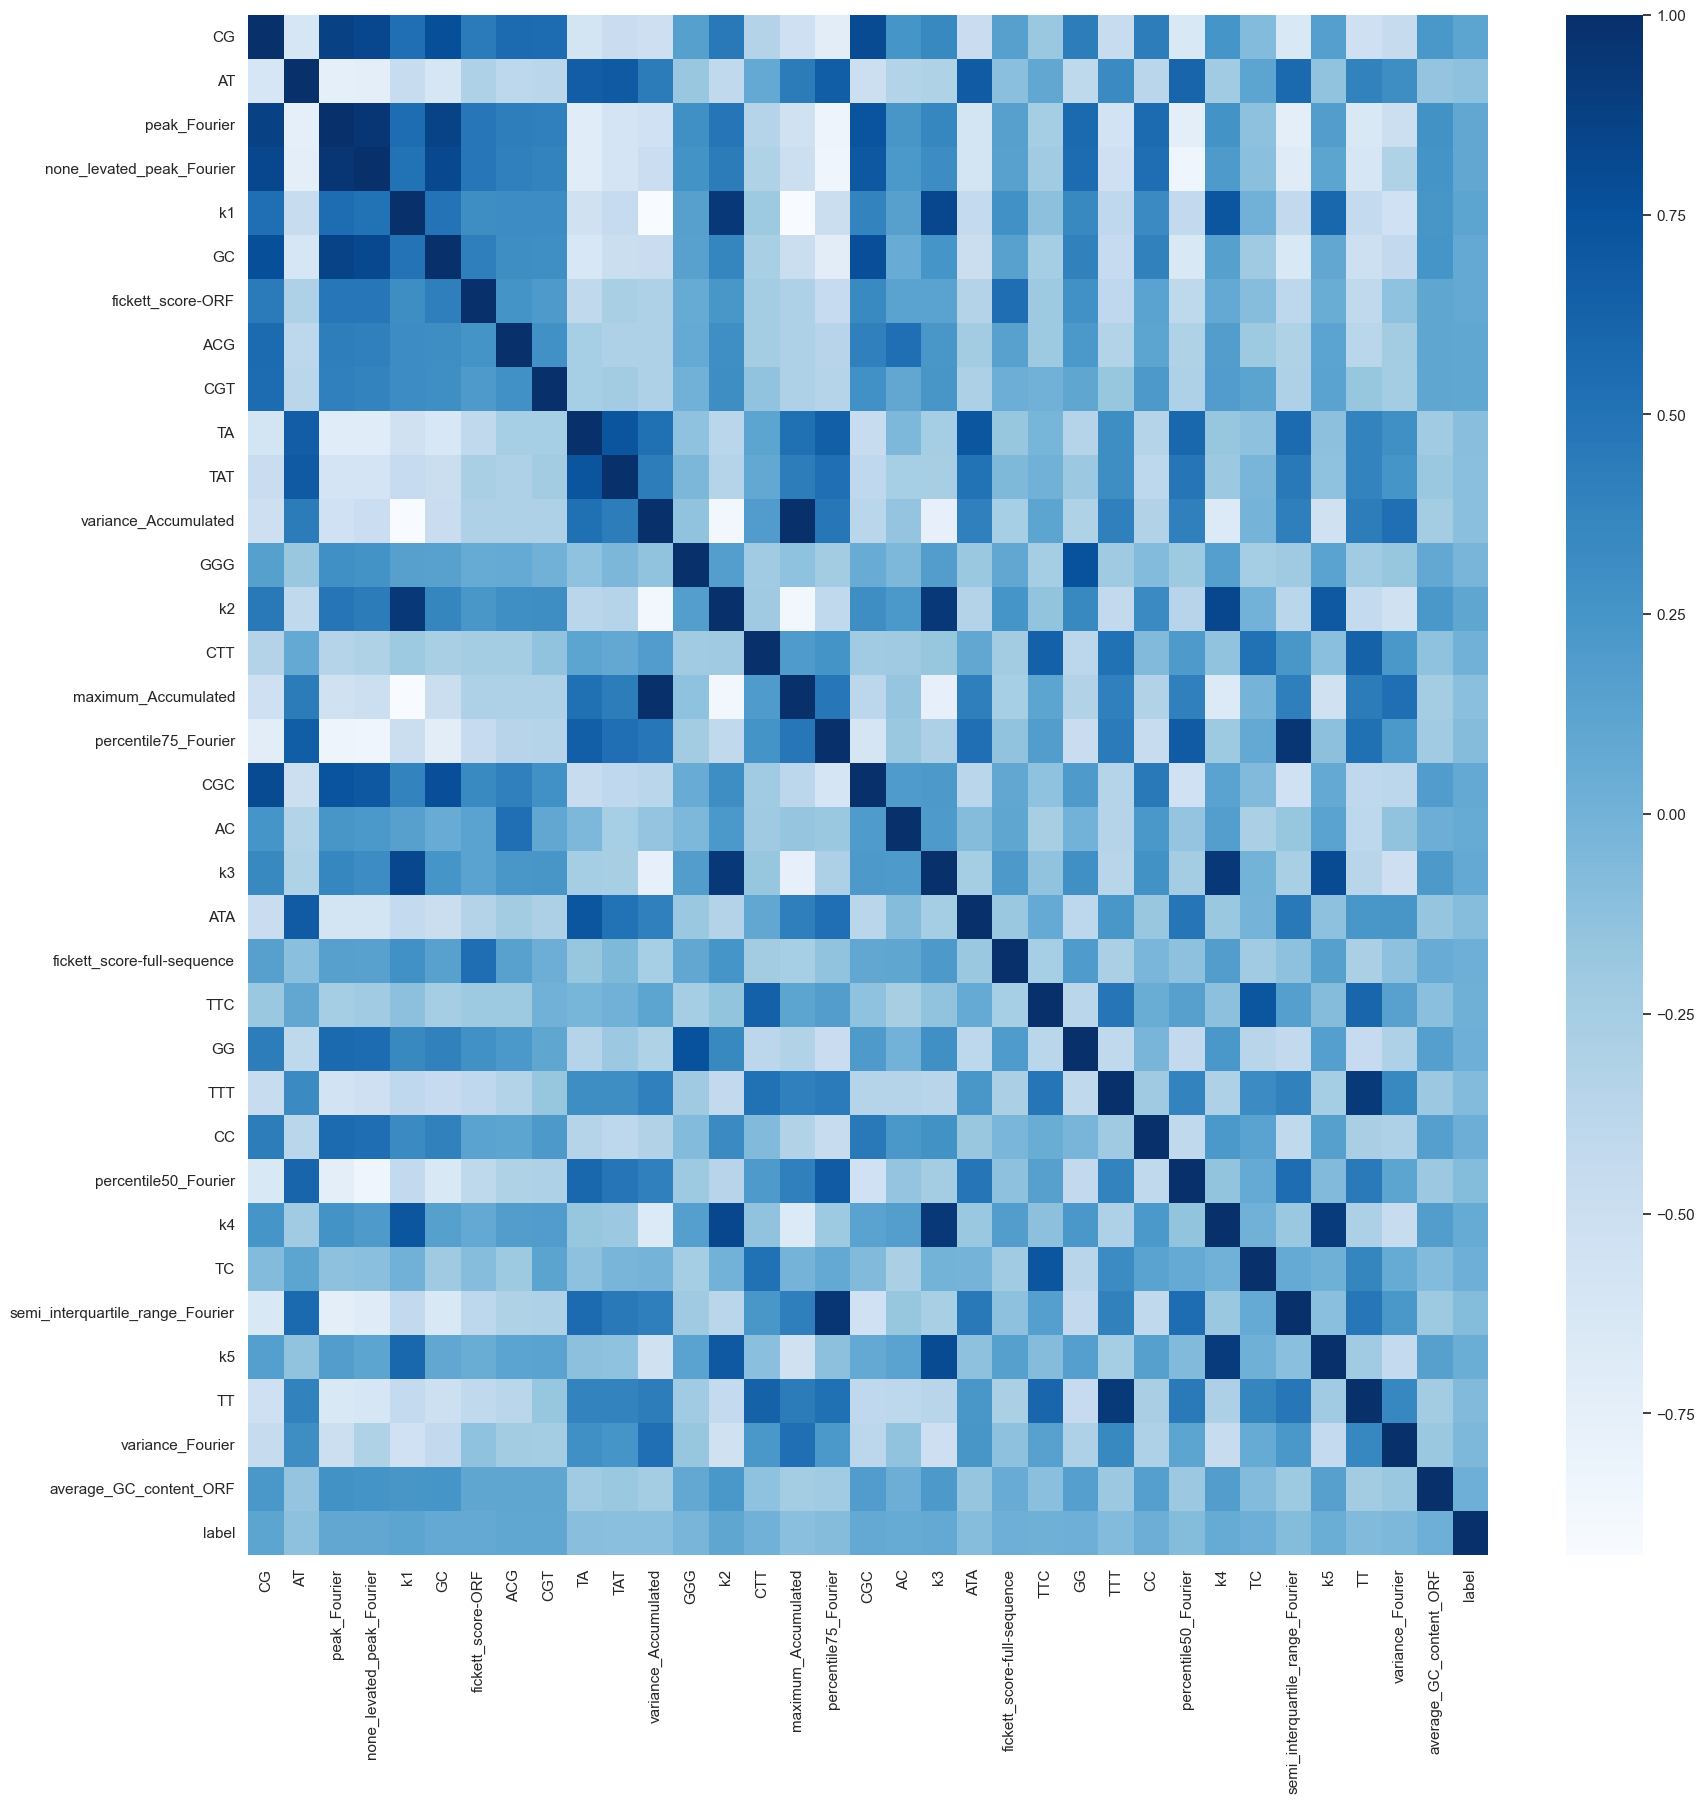

In [51]:
plt.figure(figsize = (20, 20))
sns.heatmap(df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end'], axis = 1).corr(), cmap = 'Blues')
plt.show()

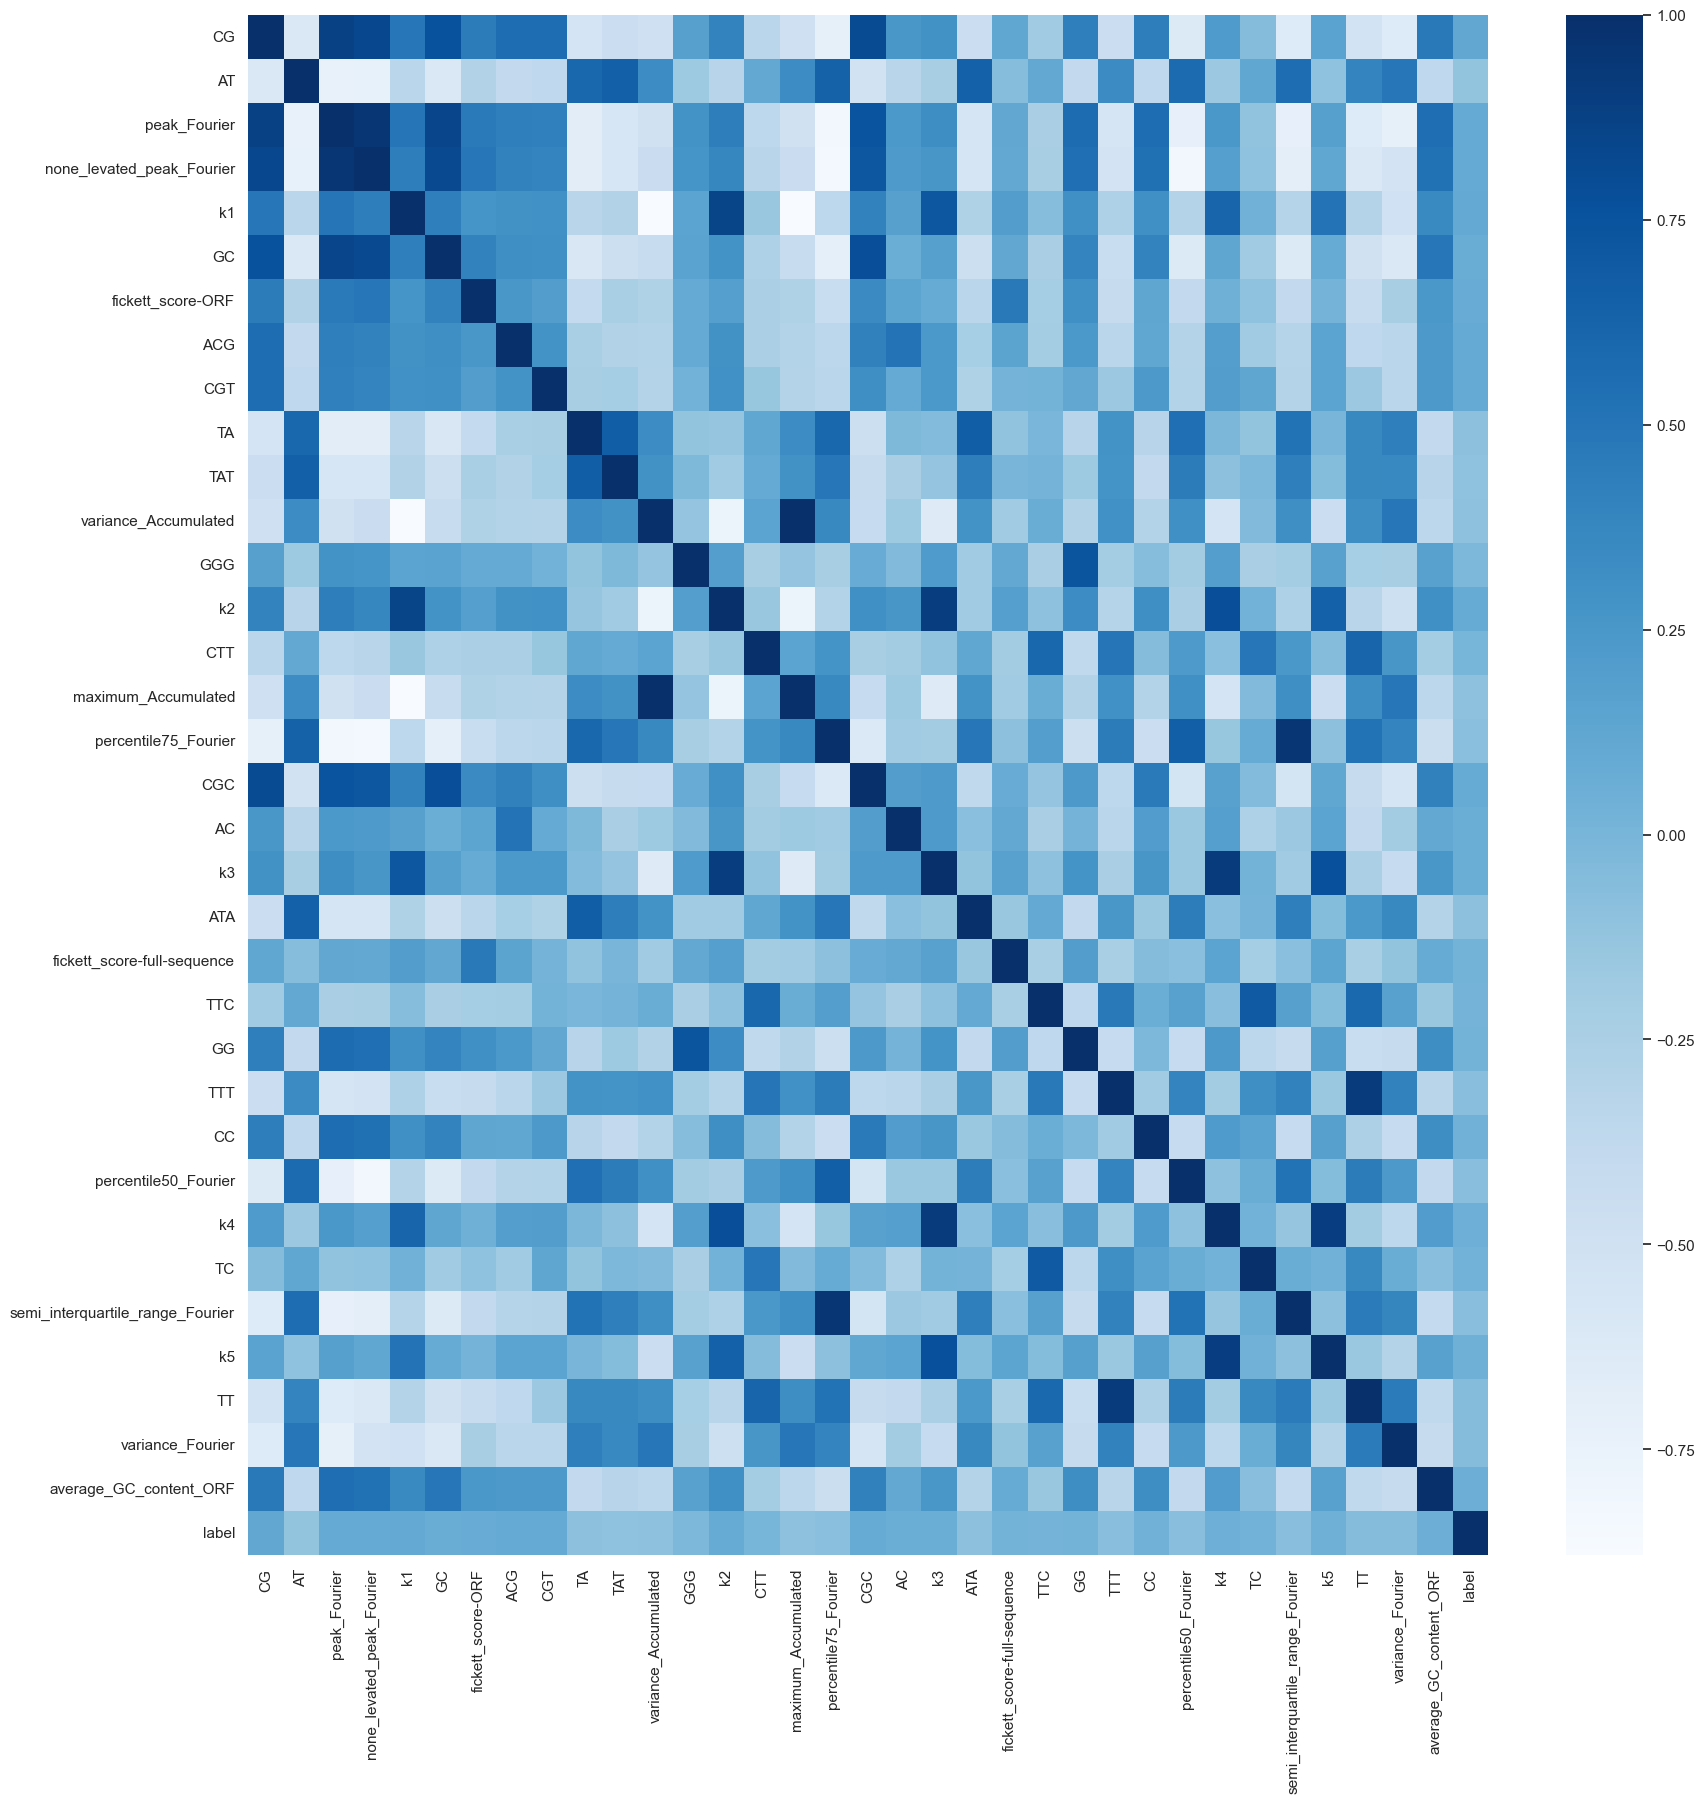

In [52]:
plt.figure(figsize = (20, 20))
sns.heatmap(df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end'], axis = 1).corr(method = 'spearman'), cmap = 'Blues')
plt.show()

In [7]:
df = df.drop(['sample_standard_deviation_Accumulated', 
              'population_standard_deviation_Accumulated', 
              'amplitude_Accumulated', 'average_Fourier',
              'median_Fourier', 'interquartile_range_Fourier'], axis = 1)


C:\Users\misha\AppData\Local\Temp\ipykernel_7096\1980670898.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = relevant_features["label"].iloc[1:l], y = relevant_features.index[1:l], palette = "viridis")


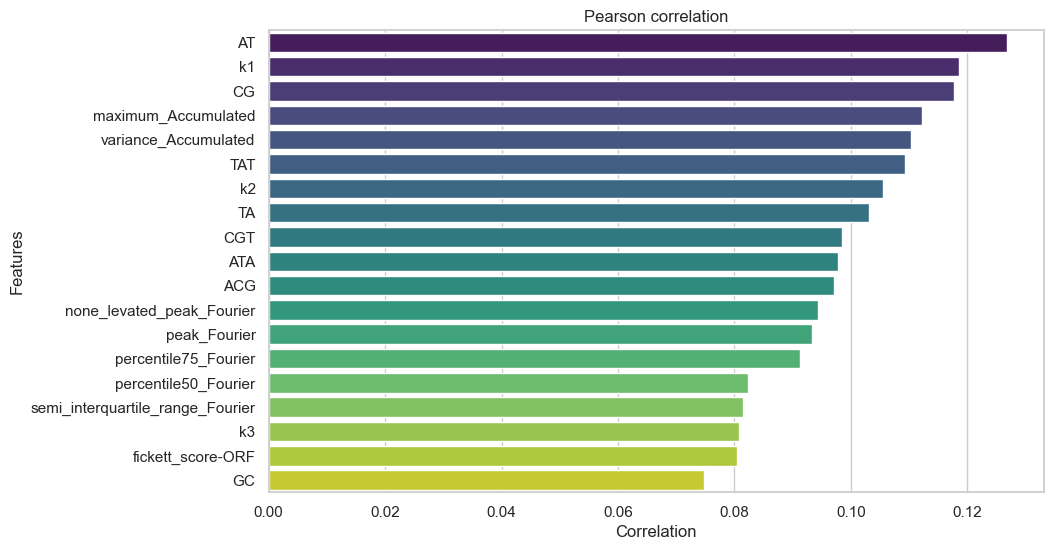

In [49]:
cor = df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end'], axis = 1).corr()
cor_target = abs(cor["label"])

relevant_features = cor_target
relevant_features = pd.DataFrame(relevant_features)
relevant_features = relevant_features.sort_values("label" , ascending = False)

plt.figure(figsize = (10, 6))
sns.barplot(x = relevant_features["label"].iloc[1:l], y = relevant_features.index[1:l], palette = "viridis")

plt.title('Pearson correlation')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.savefig("Pearson correlation.png")
plt.show()

C:\Users\misha\AppData\Local\Temp\ipykernel_7096\1298611228.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = relevant_features["label"].iloc[1:l], y = relevant_features.index[1:l], palette = "viridis")


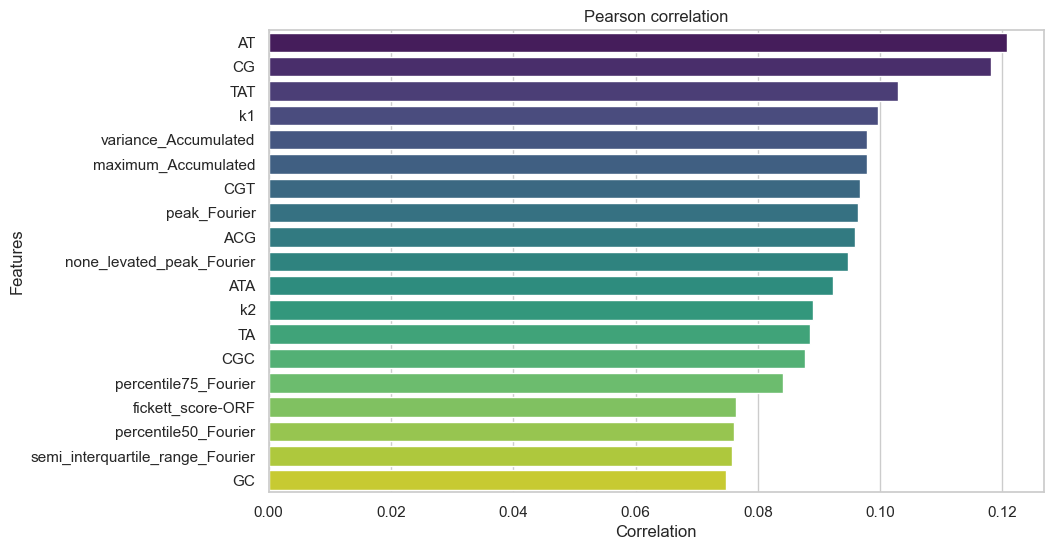

In [50]:
cor = df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end'], axis = 1).corr(method = 'spearman')
cor_target = abs(cor["label"])

relevant_features = cor_target
relevant_features = pd.DataFrame(relevant_features)
relevant_features = relevant_features.sort_values("label" , ascending = False)

plt.figure(figsize = (10, 6))
sns.barplot(x = relevant_features["label"].iloc[1:l], y = relevant_features.index[1:l], palette = "viridis")

plt.title('Pearson correlation')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.savefig("Pearson correlation.png")
plt.show()

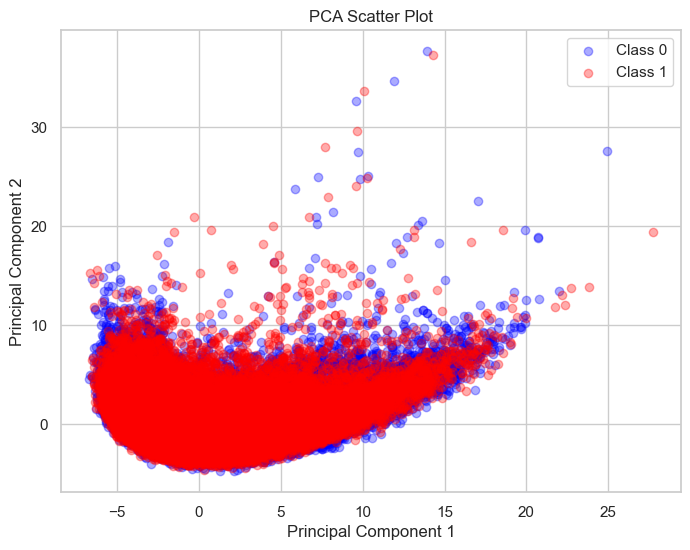

In [60]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end', 'label'], axis = 1))

pca = PCA(n_components = 2)
x_pca = pca.fit_transform(x_scaled)

evinced_interaction_column = df['label']

filtered_class_0 = x_pca[evinced_interaction_column == 0]
filtered_class_1 = x_pca[evinced_interaction_column == 1]

plt.figure(figsize = (8, 6))
plt.scatter(filtered_class_0[:, 0], filtered_class_0[:, 1], c = 'blue', label = 'Class 0', alpha = 0.33)
plt.scatter(filtered_class_1[:, 0], filtered_class_1[:, 1], c = 'red', label = 'Class 1', alpha = 0.33)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.legend()
plt.grid(True)
plt.show()

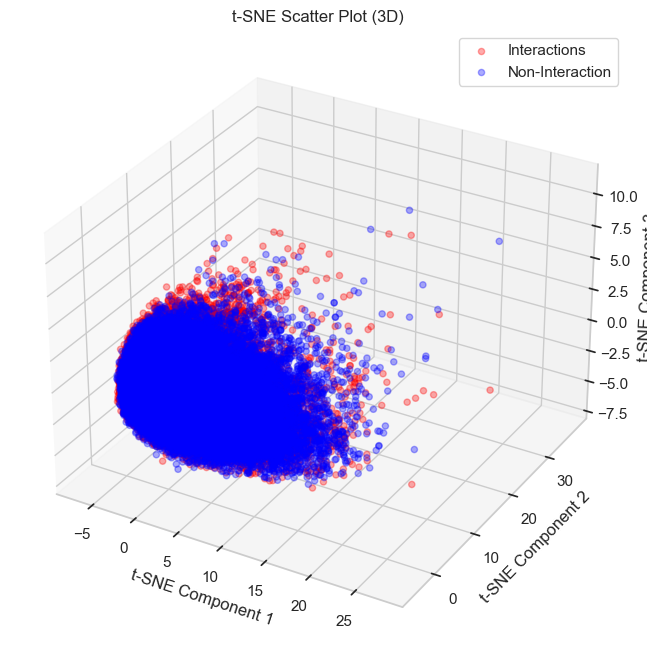

In [64]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end', 'label'], axis = 1))

pca = PCA(n_components = 3)
x_pca = pca.fit_transform(x_scaled)

evinced_interaction_column = df['label']

filtered_class_0_umap = x_pca[evinced_interaction_column == 0]
filtered_class_1_umap = x_pca[evinced_interaction_column == 1]

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(filtered_class_1_umap[:, 0], filtered_class_1_umap[:, 1], filtered_class_1_umap[:, 2], c = 'red', label = 'Interactions', alpha = 0.33)
ax.scatter(filtered_class_0_umap[:, 0], filtered_class_0_umap[:, 1], filtered_class_0_umap[:, 2], c = 'blue', label = 'Non-Interaction', alpha = 0.33)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('t-SNE Scatter Plot (3D)')
ax.legend()
plt.show()

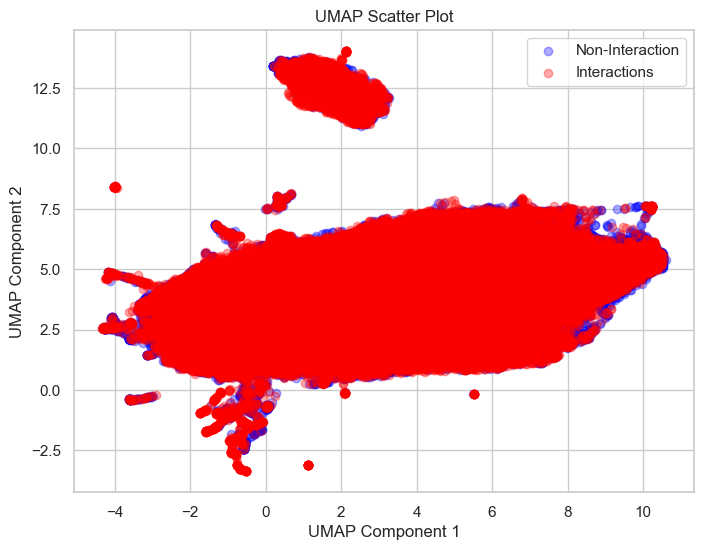

In [61]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end', 'label'], axis = 1))

umap_model = umap.UMAP(n_components = 2)
x_umap = umap_model.fit_transform(x_scaled)

evinced_interaction_column = df['label']

filtered_class_0_umap = x_umap[evinced_interaction_column == 0]
filtered_class_1_umap = x_umap[evinced_interaction_column == 1]

plt.figure(figsize = (8, 6))
plt.scatter(filtered_class_0_umap[:, 0], filtered_class_0_umap[:, 1], c = 'blue', label = 'Non-Interaction', alpha = 0.33)
plt.scatter(filtered_class_1_umap[:, 0], filtered_class_1_umap[:, 1], c = 'red', label = 'Interactions', alpha = 0.33)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Scatter Plot')
plt.legend()
plt.grid(True)
plt.show()

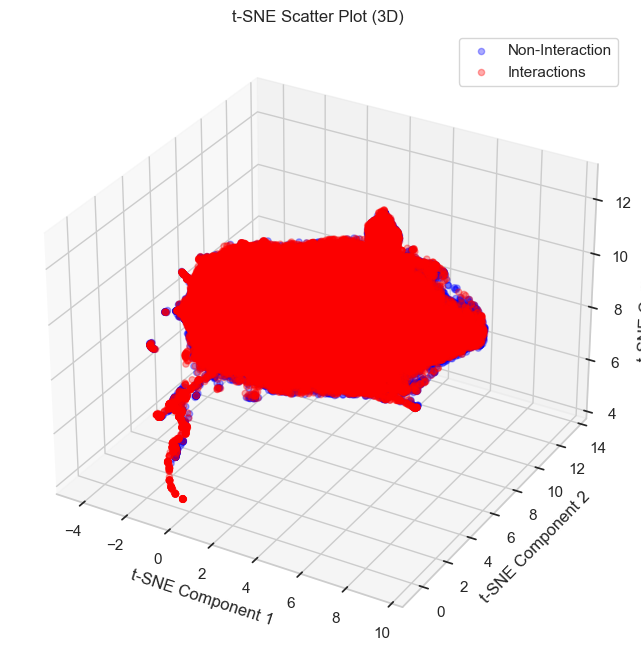

In [62]:
from mpl_toolkits.mplot3d import Axes3D

scaler = StandardScaler()
x_scaled = scaler.fit_transform(df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end', 'label'], axis = 1))

umap_model = umap.UMAP(n_components=3)
x_umap = umap_model.fit_transform(x_scaled)

evinced_interaction_column = df['label']

filtered_class_0_umap = x_umap[evinced_interaction_column == 0]
filtered_class_1_umap = x_umap[evinced_interaction_column == 1]

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(filtered_class_0_umap[:, 0], filtered_class_0_umap[:, 1], filtered_class_0_umap[:, 2], c = 'blue', label = 'Non-Interaction', alpha = 0.33)
ax.scatter(filtered_class_1_umap[:, 0], filtered_class_1_umap[:, 1], filtered_class_1_umap[:, 2], c = 'red', label = 'Interactions', alpha = 0.33)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('t-SNE Scatter Plot (3D)')
ax.legend()
plt.show()


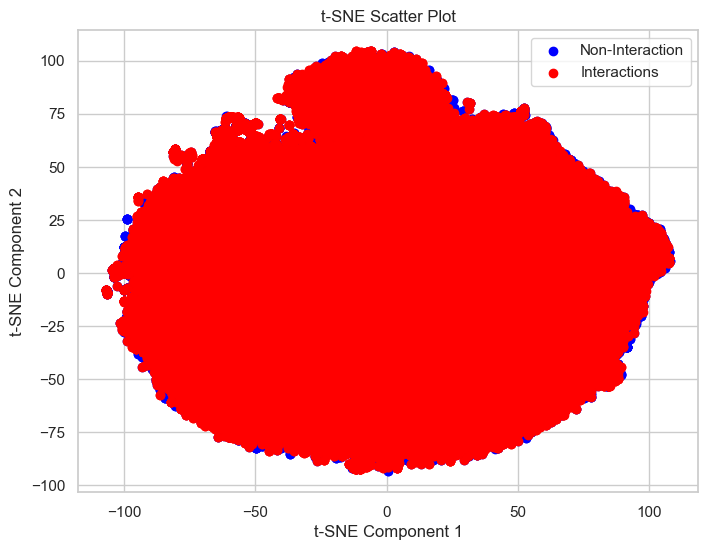

In [66]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end', 'label'], axis = 1))

tsne_model = TSNE(n_components = 2, random_state = 42)
x_tsne = tsne_model.fit_transform(x_scaled)

evinced_interaction_column = df['label']

filtered_class_0_tsne = x_tsne[evinced_interaction_column == 0]
filtered_class_1_tsne = x_tsne[evinced_interaction_column == 1]

plt.figure(figsize = (8, 6))
plt.scatter(filtered_class_0_tsne[:, 0], filtered_class_0_tsne[:, 1], c = 'blue', label = 'Non-Interaction')
plt.scatter(filtered_class_1_tsne[:, 0], filtered_class_1_tsne[:, 1], c = 'red', label = 'Interactions')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Scatter Plot')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df.drop(['seq_overlap', 'seq_med', 'n_start', 'n_end', 'label'], axis = 1))

tsne_model = TSNE(n_components = 3, random_state = 42)
x_tsne = tsne_model.fit_transform(x_scaled)

evinced_interaction_column = df['label']

filtered_class_0_tsne = x_tsne[evinced_interaction_column == 0]
filtered_class_1_tsne = x_tsne[evinced_interaction_column == 1]

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(filtered_class_0_tsne[:, 0], filtered_class_0_tsne[:, 1], filtered_class_0_tsne[:, 2], c = 'blue', label='Non-Interaction')
ax.scatter(filtered_class_1_tsne[:, 0], filtered_class_1_tsne[:, 1], filtered_class_1_tsne[:, 2], c = 'red', label='Interactions')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('t-SNE Scatter Plot (3D)')
ax.legend()
plt.show()

KeyboardInterrupt: 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['label', 'n_start', 'n_end'], axis = 1),
                                                     df['label'], train_size = 0.8, random_state = 1212)

X_train_seq1 = X_train['seq_overlap']
X_train_seq2 = X_train['seq_med']
X_train = X_train.drop(['seq_overlap', 'seq_med'], axis = 1)

X_test_seq1 = X_test['seq_overlap']
X_test_seq2 = X_test['seq_med']
X_test = X_test.drop(['seq_overlap', 'seq_med'], axis = 1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components = 20)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level = True)
tokenizer.fit_on_texts(X_test_seq1)
X_train_seq1 = np.array(tokenizer.texts_to_sequences(X_train_seq1))
X_train_seq2 = np.array(tokenizer.texts_to_sequences(X_train_seq2))
X_test_seq1 = np.array(tokenizer.texts_to_sequences(X_test_seq1))
X_test_seq2 = np.array(tokenizer.texts_to_sequences(X_test_seq2))

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [31]:
X_test_seq1.shape

(35391, 900)

In [40]:
inp_seq1 = Input(shape = (900, 1))
features1 = BatchNormalization()(inp_seq1)
features1 = Conv1D(32, 3, padding = 'same', activation = 'elu')(features1)
features1 = MaxPooling1D(2)(features1)
features1 = BatchNormalization()(features1)
features1 = Conv1D(64, 3, padding = 'same', activation = 'elu')(features1)
features1 = MaxPooling1D(2)(features1)
features1 = BatchNormalization()(features1)
features1 = Conv1D(128, 3, padding = 'same', activation = 'elu')(features1)
features1 = MaxPooling1D(2)(features1)
features1 = Flatten()(features1)
features1 = Dense(256, activation = 'elu')(features1)

inp_seq2 = Input(shape = (300, 1))
features2 = BatchNormalization()(inp_seq2)
features2 = Conv1D(32, 3, padding = 'same', activation = 'elu')(features2)
features2 = MaxPooling1D(2)(features2)
features2 = BatchNormalization()(features2)
features2 = Conv1D(64, 3, padding = 'same', activation = 'elu')(features2)
features2 = MaxPooling1D(2)(features2)
features2 = Flatten()(features2)
features2 = Dense(256, activation = 'elu')(features2)

inp_feature3 = Input(shape = (X_train.shape[1], ))
features3 = BatchNormalization()(inp_feature3)
features3 = Dense(256, activation = 'elu')(features3)
features3 = BatchNormalization()(features3)
features3 = Dense(128, activation = 'elu')(features3)
features3 = BatchNormalization()(features3)
features3 = Dense(64, activation = 'elu')(features3)

concat = concatenate([features1, features2, features3])
concat = Dense(512, activation = 'elu')(concat)
concat = BatchNormalization()(concat)
concat = Dense(128, activation = 'elu')(concat)
concat = Dense(2, activation = 'softmax')(concat)

model = Model(inputs = [inp_seq1, inp_seq2, inp_feature3], outputs = concat)
optimizer = Nadam(learning_rate = 0.01)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [41]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 900, 1)]     0           []                               
                                                                                                  
 batch_normalization_68 (BatchN  (None, 900, 1)      4           ['input_24[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_40 (Conv1D)             (None, 900, 32)      128         ['batch_normalization_68[0][0]'] 
                                                                                                  
 max_pooling1d_40 (MaxPooling1D  (None, 450, 32)     0           ['conv1d_40[0][0]']        

In [42]:
hist = model.fit([X_train_seq1, X_train_seq2, X_train], y_train, batch_size = 256, epochs = 20, 
                 validation_data = [[X_test_seq1, X_test_seq2, X_test], y_test])

Epoch 1/20
553/553 [==============================] - 55s 85ms/step - loss: 0.7014 - accuracy: 0.5731 - val_loss: 0.6709 - val_accuracy: 0.5771
Epoch 2/20
553/553 [==============================] - 48s 86ms/step - loss: 0.6642 - accuracy: 0.5883 - val_loss: 0.7604 - val_accuracy: 0.4917
Epoch 3/20
553/553 [==============================] - 47s 85ms/step - loss: 0.6512 - accuracy: 0.6102 - val_loss: 0.6792 - val_accuracy: 0.5636
Epoch 4/20
553/553 [==============================] - 47s 85ms/step - loss: 0.6234 - accuracy: 0.6453 - val_loss: 0.7212 - val_accuracy: 0.5585
Epoch 5/20
553/553 [==============================] - 47s 84ms/step - loss: 0.5740 - accuracy: 0.6948 - val_loss: 0.6154 - val_accuracy: 0.6611
Epoch 6/20
553/553 [==============================] - 47s 85ms/step - loss: 0.5075 - accuracy: 0.7464 - val_loss: 0.6199 - val_accuracy: 0.6833
Epoch 7/20
553/553 [==============================] - 47s 84ms/step - loss: 0.4207 - accuracy: 0.8042 - val_loss: 0.6280 - val_accuracy:

1106/1106 [==============================] - 8s 7ms/step


<Axes: >

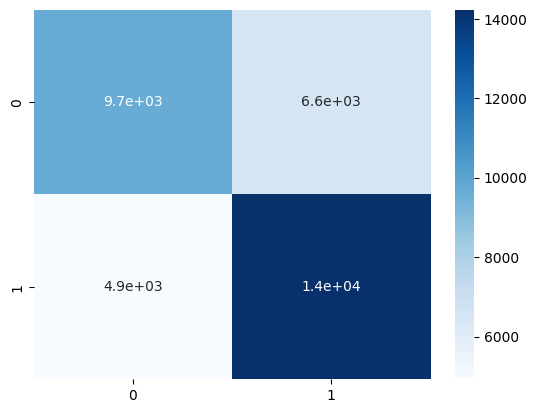

In [43]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(model.predict([X_test_seq1, X_test_seq2, X_test]), axis = 1)), annot = True, cmap = 'Blues')

In [45]:
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(model.predict([X_test_seq1, X_test_seq2, X_test]), axis = 1)))

1106/1106 [==============================] - 8s 7ms/step
              precision    recall  f1-score   support

           0       0.66      0.60      0.63     16237
           1       0.68      0.74      0.71     19154

    accuracy                           0.68     35391
   macro avg       0.67      0.67      0.67     35391
weighted avg       0.67      0.68      0.67     35391



In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['label', 'n_start', 'n_end'], axis = 1),
                                                     df[['label', 'n_start', 'n_end']], train_size = 0.8, random_state = 1212)

X_train_seq1 = X_train['seq_overlap']
X_train_seq2 = X_train['seq_med']
X_train = X_train.drop(['seq_overlap', 'seq_med'], axis = 1)

X_test_seq1 = X_test['seq_overlap']
X_test_seq2 = X_test['seq_med']
X_test = X_test.drop(['seq_overlap', 'seq_med'], axis = 1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components = 20)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level = True)
tokenizer.fit_on_texts(X_test_seq1)
X_train_seq1 = np.array(tokenizer.texts_to_sequences(X_train_seq1))
X_train_seq2 = np.array(tokenizer.texts_to_sequences(X_train_seq2))
X_test_seq1 = np.array(tokenizer.texts_to_sequences(X_test_seq1))
X_test_seq2 = np.array(tokenizer.texts_to_sequences(X_test_seq2))

y_train_start = np.array(y_train['n_start'])
y_train_end = np.array(y_train['n_end'])
y_test_start = np.array(y_test['n_start'])
y_test_end = np.array(y_test['n_end'])
y_train = tf.keras.utils.to_categorical(y_train['label'])
y_test = tf.keras.utils.to_categorical(y_test['label'])

In [51]:
inp_seq1 = Input(shape = (900, 1))
features1 = BatchNormalization()(inp_seq1)
features1 = Conv1D(32, 3, padding = 'same', activation = 'elu')(features1)
features1 = MaxPooling1D(2)(features1)
features1 = BatchNormalization()(features1)
features1 = Conv1D(64, 3, padding = 'same', activation = 'elu')(features1)
features1 = MaxPooling1D(2)(features1)
features1 = BatchNormalization()(features1)
features1 = Conv1D(128, 3, padding = 'same', activation = 'elu')(features1)
features1 = MaxPooling1D(2)(features1)
features1 = Flatten()(features1)
features1 = Dense(256, activation = 'elu')(features1)

inp_seq2 = Input(shape = (300, 1))
features2 = BatchNormalization()(inp_seq2)
features2 = Conv1D(32, 3, padding = 'same', activation = 'elu')(features2)
features2 = MaxPooling1D(2)(features2)
features2 = BatchNormalization()(features2)
features2 = Conv1D(64, 3, padding = 'same', activation = 'elu')(features2)
features2 = MaxPooling1D(2)(features2)
features2 = Flatten()(features2)
features2 = Dense(256, activation = 'elu')(features2)

inp_feature3 = Input(shape = (X_train.shape[1], ))
features3 = BatchNormalization()(inp_feature3)
features3 = Dense(256, activation = 'elu')(features3)
features3 = BatchNormalization()(features3)
features3 = Dense(128, activation = 'elu')(features3)
features3 = BatchNormalization()(features3)
features3 = Dense(64, activation = 'elu')(features3)

concat = concatenate([features1, features2, features3])
concat = Dense(512, activation = 'elu')(concat)
concat = BatchNormalization()(concat)
concat = Dense(128, activation = 'elu')(concat)
concat = BatchNormalization()(concat)

out_start = Dense(128, activation = 'elu')(concat)
out_start = Dense(1, activation = 'linear', name = 'out_start')(out_start)

out_end = Dense(128, activation = 'elu')(concat)
out_end = Dense(1, activation = 'linear', name = 'out_end')(out_end)

out_classification = Dense(128, activation = 'elu')(concat)
out_classification = Dense(2, activation = 'softmax', name = 'out_classification')(out_classification)

model = Model(inputs = [inp_seq1, inp_seq2, inp_feature3], outputs = [out_classification, out_start, out_end])
optimizer = Nadam(learning_rate = 0.01)
model.compile(optimizer = optimizer, loss = ['binary_crossentropy', 'mean_squared_error', 'mean_squared_error'],
               metrics = ['accuracy'])

model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 900, 1)]     0           []                               
                                                                                                  
 batch_normalization_160 (Batch  (None, 900, 1)      4           ['input_49[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 conv1d_80 (Conv1D)             (None, 900, 32)      128         ['batch_normalization_160[0][0]']
                                                                                                  
 max_pooling1d_80 (MaxPooling1D  (None, 450, 32)     0           ['conv1d_80[0][0]']       

In [52]:
earlystopping = EarlyStopping(monitor = 'val_out_classification_accuracy', patience = 5, restore_best_weights = True, verbose = True)
reducelr = ReduceLROnPlateau(monitor = 'val_out_classification_accuracy', patience = 3, factor = 0.1, verbose = True)

In [53]:
hist = model.fit([X_train_seq1, X_train_seq2, X_train], [y_train, y_train_start, y_train_end], batch_size = 256, epochs = 50, 
                 validation_data = [[X_test_seq1, X_test_seq2, X_test], [y_test, y_test_start, y_test_end]],
                 callbacks = [earlystopping, reducelr])

Epoch 1/50
553/553 [==============================] - 67s 100ms/step - loss: 21994.3145 - out_classification_loss: 0.6972 - out_start_loss: 54.4058 - out_end_loss: 21939.2227 - out_classification_accuracy: 0.5704 - out_start_accuracy: 0.3210 - out_end_accuracy: 0.0022 - val_loss: 22978.2266 - val_out_classification_loss: 0.6898 - val_out_start_loss: 53.5741 - val_out_end_loss: 22923.9648 - val_out_classification_accuracy: 0.5223 - val_out_start_accuracy: 0.8361 - val_out_end_accuracy: 0.0010 - lr: 0.0100
Epoch 2/50
553/553 [==============================] - 54s 97ms/step - loss: 21115.7988 - out_classification_loss: 0.6667 - out_start_loss: 53.9726 - out_end_loss: 21061.1523 - out_classification_accuracy: 0.5849 - out_start_accuracy: 0.2750 - out_end_accuracy: 3.5320e-05 - val_loss: 21169.1660 - val_out_classification_loss: 0.6658 - val_out_start_loss: 53.4171 - val_out_end_loss: 21115.0840 - val_out_classification_accuracy: 0.5858 - val_out_start_accuracy: 0.0182 - val_out_end_accurac

In [66]:
predictions = model.predict([X_test_seq1, X_test_seq2, X_test])

1106/1106 [==============================] - 9s 8ms/step


              precision    recall  f1-score   support

           0       0.70      0.70      0.70     16237
           1       0.75      0.74      0.75     19154

    accuracy                           0.73     35391
   macro avg       0.72      0.72      0.72     35391
weighted avg       0.73      0.73      0.73     35391



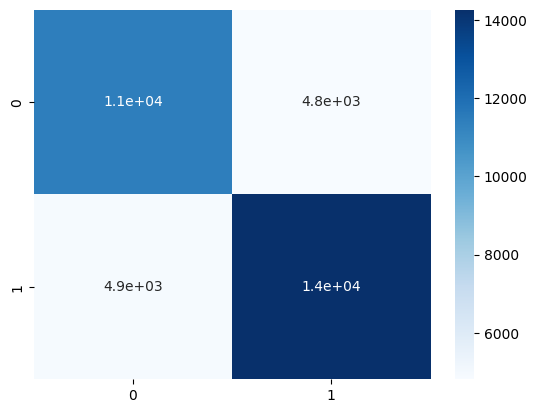

In [59]:
sns.heatmap(confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(predictions[0], axis = 1)), annot = True, cmap = 'Blues')
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(predictions[0], axis = 1)))

C:\Users\misha\AppData\Local\Temp\ipykernel_9344\2387263145.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test_start, predictions[1], cmap = 'viridis')


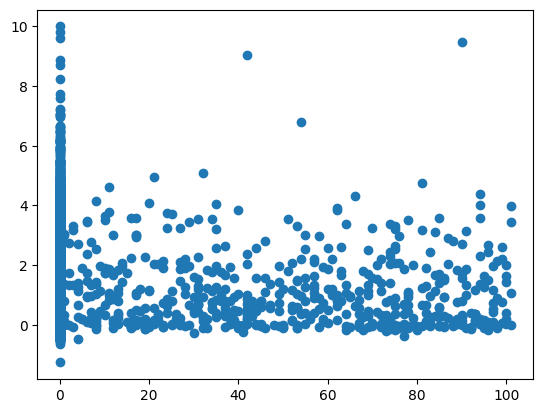

In [71]:
predictions[1] = np.minimum(predictions[1], 10)
plt.scatter(y_test_start, predictions[1], cmap = 'viridis')

C:\Users\misha\AppData\Local\Temp\ipykernel_9344\1398939558.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test_end, predictions[2], cmap = 'viridis')


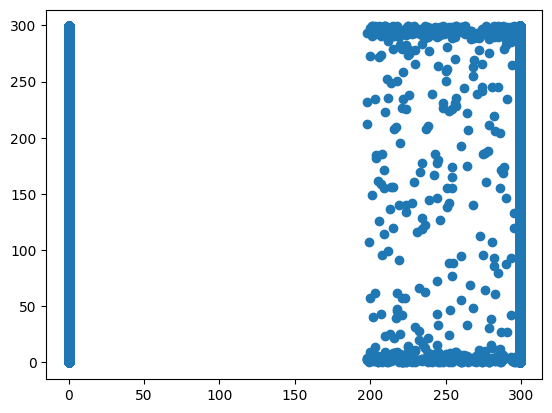

In [73]:
predictions[2] = np.minimum(predictions[2], 299)
predictions[2] = np.maximum(predictions[2], 0)
plt.scatter(y_test_end, predictions[2], cmap = 'viridis')